In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES']='2'
# for visual studio code
os.chdir('/home/r10222035/boosted_V_ML_test/CNN/')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime
import pandas as pd
from tqdm import tqdm
from readTFR import *

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

2022-11-21 10:32:02.192106: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Training data 

In [2]:
kappa = 0.15
nevent = '700k'

In [5]:
batch_size = 512
shuffle_size_tr = 0
dim_image = [[75, 75], [[-0.8, 0.8], [-0.8, 0.8]]]

In [18]:
sample_dir = f'/home/r10222035/boosted_V_ML_test/sample/samples_kappa{kappa}-{nevent}/'
print(f'Read data from {sample_dir}')
data_tr = os.path.join(sample_dir, 'train.tfrecord')
data_vl = os.path.join(sample_dir, 'valid.tfrecord')
data_te = os.path.join(sample_dir, 'test.tfrecord')

dataset_tr, tr_total = get_dataset(data_tr, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=shuffle_size_tr)
dataset_vl, vl_total = get_dataset(data_vl, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=0)
dataset_te, te_total = get_dataset(data_te, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=0)

labels_tr = np.vstack([x[1] for x in dataset_tr])
labels_vl = np.vstack([x[1] for x in dataset_vl])
labels_te = np.vstack([x[1] for x in dataset_te])

y_tr = np.argmax(labels_tr, axis=1)
y_vl = np.argmax(labels_vl, axis=1)
y_te = np.argmax(labels_te, axis=1)

The data set contains images
The data set contains images
The data set contains images


In [9]:
def count_sample_size(y):
    # count sample size for 3 types
    size = [0,0,0]
    size[0] = (y == 0).sum()
    size[1] = (y == 1).sum()
    size[2] = (y == 2).sum()
    return size

In [10]:
train_size = count_sample_size(y_tr)
print('Training size:', train_size)

validation_size = count_sample_size(y_vl)
print('Validation size:', validation_size)

test_size = count_sample_size(y_te)
print('Testing size:', test_size)

Training size: [11367, 12071, 10354]
Validation size: [2928, 2924, 2596]
Testing size: [3516, 3700, 3280]


In [15]:
for x in dataset_te.take(1):
    print(x[0][0].shape)
    print(x[0][0][:,:,0])
    a = x[0][0][:,:,0]
    b = x[0][0][:,:,1]
print(a)
c = tf.expand_dims(a, -1)
d = tf.expand_dims(b, -1)



(75, 75, 2)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(75, 75), dtype=float32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(75, 75), dtype=float32)


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'Flatten'

# Training 

## CNN

In [32]:
class CNN(tf.keras.Model):
    def __init__(self, name='CNN', dim_image=(75, 75, 2), n_class=3):
        super(CNN, self).__init__(name=name)
        
        self.ptqk = tf.keras.Sequential([
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, (6,6), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(128, (4,4), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(256, (6,6), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Dropout(0.5),
        ])
        
        """Output Layer"""
        self._output = tf.keras.layers.Dense(n_class, activation='softmax')
        
    @tf.function
    def call(self, inputs, training=False):
        latent_ptqk = self.ptqk(inputs)
        
        return self._output(latent_ptqk)

In [33]:
# Training parameters
train_epochs = 500
patience = 10
min_delta = 0.
learning_rate = 1e-4                                    
save_model_name = f'best_model_CNN_kappa{kappa}-{nevent}/'

In [34]:
# Create the model  
history=0
model = CNN(dim_image=[75,75,2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point    = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', 
                                                    verbose=1, save_best_only=True)

history = model.fit(dataset_tr, validation_data=dataset_vl , epochs=train_epochs, batch_size=batch_size, callbacks=[early_stopping, check_point])

Epoch 1/500
    131/Unknown - 5s 31ms/step - loss: 9.6179 - accuracy: 0.4398
Epoch 1: val_loss improved from inf to 5.61434, saving model to best_model_CNN_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN_kappa0.15-100k/assets


132/132 [==============================] - 7s 50ms/step - loss: 9.5877 - accuracy: 0.4395 - val_loss: 5.6143 - val_accuracy: 0.4505
Epoch 2/500
 89/132 [===================>..........] - ETA: 1s - loss: 4.5536 - accuracy: 0.5278

KeyboardInterrupt: 

## CNN2 

In [16]:
class CNNsq(tf.keras.Model):
    def __init__(self, name='CNNsq', dim_image=(75, 75, 2), n_class=3):
        super(CNNsq, self).__init__(name=name)
        
        """h2ptj Channel"""
        self.h2ptj = tf.keras.Sequential([
            # input tensor dimension must be (batch_size, rows, cols, channels)
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:, :, :, 0], -1)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(128, (5,5), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256, (5,5), padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Dropout(0.5),
        ])

        """h2Qkj Channel"""
        self.h2Qkj = tf.keras.Sequential([
            # input tensor dimension must be (batch_size, rows, cols, channels)
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:, :, :, 1], -1)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (4,4), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, (4,4), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(256, (6,6), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Dropout(0.5),
        ])
        
        """Output Layer"""
        self._output = tf.keras.layers.Dense(n_class, activation='softmax')
        
    @tf.function
    def call(self, inputs, training=False):
        """h2ptj"""
        latent_h2ptj = self.h2ptj(inputs)

        """h2Qkj"""
        latent_h2Qkj = self.h2Qkj(inputs)
        
        """Output"""
        latent_all = tf.concat([latent_h2ptj, latent_h2Qkj], axis=1)
        
        return self._output(latent_all)

In [19]:
# Training parameters
train_epochs = 500
patience = 10
min_delta = 0.
learning_rate = 1e-4                                    
save_model_name = f'best_model_CNNsq_kappa{kappa}-{nevent}/'

In [20]:
# Create the model  
history=0
model = CNNsq(dim_image=[75,75,2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point    = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', 
                                                    verbose=1, save_best_only=True)

history = model.fit(dataset_tr, validation_data=dataset_vl , epochs=train_epochs, batch_size=batch_size, callbacks=[early_stopping, check_point])

Epoch 1/500


2022-10-06 13:13:20.408412: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-06 13:13:31.728495: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-06 13:13:31.729413: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-06 13:13:31.729479: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-06 13:13:31.730384: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-06 13:13:31.730487: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-10-06 13:13:33.657472: I tensorflow/stream_executor/cuda/c

     66/Unknown - 41s 116ms/step - loss: 9.5441 - accuracy: 0.4212
Epoch 1: val_loss improved from inf to 6.42228, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 48s 217ms/step - loss: 9.5441 - accuracy: 0.4212 - val_loss: 6.4223 - val_accuracy: 0.4458
Epoch 2/500
66/66 [==============================] - ETA: 0s - loss: 4.8420 - accuracy: 0.5396
Epoch 2: val_loss improved from 6.42228 to 3.82283, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 182ms/step - loss: 4.8420 - accuracy: 0.5396 - val_loss: 3.8228 - val_accuracy: 0.5616
Epoch 3/500
66/66 [==============================] - ETA: 0s - loss: 3.1477 - accuracy: 0.6162
Epoch 3: val_loss improved from 3.82283 to 2.86134, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 186ms/step - loss: 3.1477 - accuracy: 0.6162 - val_loss: 2.8613 - val_accuracy: 0.5828
Epoch 4/500
66/66 [==============================] - ETA: 0s - loss: 2.4813 - accuracy: 0.6238
Epoch 4: val_loss improved from 2.86134 to 2.38983, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 13s 192ms/step - loss: 2.4813 - accuracy: 0.6238 - val_loss: 2.3898 - val_accuracy: 0.5939
Epoch 5/500
66/66 [==============================] - ETA: 0s - loss: 2.1190 - accuracy: 0.6296
Epoch 5: val_loss improved from 2.38983 to 2.08384, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 181ms/step - loss: 2.1190 - accuracy: 0.6296 - val_loss: 2.0838 - val_accuracy: 0.5964
Epoch 6/500
66/66 [==============================] - ETA: 0s - loss: 1.8671 - accuracy: 0.6327
Epoch 6: val_loss improved from 2.08384 to 1.84564, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 13s 191ms/step - loss: 1.8671 - accuracy: 0.6327 - val_loss: 1.8456 - val_accuracy: 0.6124
Epoch 7/500
66/66 [==============================] - ETA: 0s - loss: 1.6724 - accuracy: 0.6352
Epoch 7: val_loss improved from 1.84564 to 1.65154, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 13s 192ms/step - loss: 1.6724 - accuracy: 0.6352 - val_loss: 1.6515 - val_accuracy: 0.6143
Epoch 8/500
66/66 [==============================] - ETA: 0s - loss: 1.5150 - accuracy: 0.6379
Epoch 8: val_loss improved from 1.65154 to 1.49452, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 13s 192ms/step - loss: 1.5150 - accuracy: 0.6379 - val_loss: 1.4945 - val_accuracy: 0.6178
Epoch 9/500
66/66 [==============================] - ETA: 0s - loss: 1.3884 - accuracy: 0.6405
Epoch 9: val_loss improved from 1.49452 to 1.36333, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 183ms/step - loss: 1.3884 - accuracy: 0.6405 - val_loss: 1.3633 - val_accuracy: 0.6267
Epoch 10/500
66/66 [==============================] - ETA: 0s - loss: 1.2809 - accuracy: 0.6426
Epoch 10: val_loss improved from 1.36333 to 1.26224, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 189ms/step - loss: 1.2809 - accuracy: 0.6426 - val_loss: 1.2622 - val_accuracy: 0.6296
Epoch 11/500
66/66 [==============================] - ETA: 0s - loss: 1.1955 - accuracy: 0.6452
Epoch 11: val_loss improved from 1.26224 to 1.17915, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 183ms/step - loss: 1.1955 - accuracy: 0.6452 - val_loss: 1.1791 - val_accuracy: 0.6340
Epoch 12/500
66/66 [==============================] - ETA: 0s - loss: 1.1263 - accuracy: 0.6442
Epoch 12: val_loss improved from 1.17915 to 1.11681, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 180ms/step - loss: 1.1263 - accuracy: 0.6442 - val_loss: 1.1168 - val_accuracy: 0.6322
Epoch 13/500
66/66 [==============================] - ETA: 0s - loss: 1.0647 - accuracy: 0.6458
Epoch 13: val_loss improved from 1.11681 to 1.06180, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 186ms/step - loss: 1.0647 - accuracy: 0.6458 - val_loss: 1.0618 - val_accuracy: 0.6373
Epoch 14/500
66/66 [==============================] - ETA: 0s - loss: 1.0173 - accuracy: 0.6507
Epoch 14: val_loss improved from 1.06180 to 1.02186, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 186ms/step - loss: 1.0173 - accuracy: 0.6507 - val_loss: 1.0219 - val_accuracy: 0.6382
Epoch 15/500
66/66 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.6511
Epoch 15: val_loss improved from 1.02186 to 0.99053, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 179ms/step - loss: 0.9770 - accuracy: 0.6511 - val_loss: 0.9905 - val_accuracy: 0.6373
Epoch 16/500
66/66 [==============================] - ETA: 0s - loss: 0.9465 - accuracy: 0.6528
Epoch 16: val_loss improved from 0.99053 to 0.96659, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 184ms/step - loss: 0.9465 - accuracy: 0.6528 - val_loss: 0.9666 - val_accuracy: 0.6395
Epoch 17/500
66/66 [==============================] - ETA: 0s - loss: 0.9184 - accuracy: 0.6575
Epoch 17: val_loss improved from 0.96659 to 0.94268, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 181ms/step - loss: 0.9184 - accuracy: 0.6575 - val_loss: 0.9427 - val_accuracy: 0.6426
Epoch 18/500
66/66 [==============================] - ETA: 0s - loss: 0.8958 - accuracy: 0.6575
Epoch 18: val_loss improved from 0.94268 to 0.92268, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 177ms/step - loss: 0.8958 - accuracy: 0.6575 - val_loss: 0.9227 - val_accuracy: 0.6427
Epoch 19/500
66/66 [==============================] - ETA: 0s - loss: 0.8795 - accuracy: 0.6591
Epoch 19: val_loss improved from 0.92268 to 0.91165, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 184ms/step - loss: 0.8795 - accuracy: 0.6591 - val_loss: 0.9116 - val_accuracy: 0.6434
Epoch 20/500
66/66 [==============================] - ETA: 0s - loss: 0.8610 - accuracy: 0.6634
Epoch 20: val_loss improved from 0.91165 to 0.89817, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 182ms/step - loss: 0.8610 - accuracy: 0.6634 - val_loss: 0.8982 - val_accuracy: 0.6456
Epoch 21/500
66/66 [==============================] - ETA: 0s - loss: 0.8518 - accuracy: 0.6651
Epoch 21: val_loss did not improve from 0.89817
66/66 [==============================] - 8s 128ms/step - loss: 0.8518 - accuracy: 0.6651 - val_loss: 0.8991 - val_accuracy: 0.6394
Epoch 22/500
66/66 [==============================] - ETA: 0s - loss: 0.8360 - accuracy: 0.6676
Epoch 22: val_loss improved from 0.89817 to 0.88147, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 180ms/step - loss: 0.8360 - accuracy: 0.6676 - val_loss: 0.8815 - val_accuracy: 0.6451
Epoch 23/500
66/66 [==============================] - ETA: 0s - loss: 0.8308 - accuracy: 0.6699
Epoch 23: val_loss did not improve from 0.88147
66/66 [==============================] - 8s 128ms/step - loss: 0.8308 - accuracy: 0.6699 - val_loss: 0.8905 - val_accuracy: 0.6382
Epoch 24/500
66/66 [==============================] - ETA: 0s - loss: 0.8171 - accuracy: 0.6741
Epoch 24: val_loss improved from 0.88147 to 0.87892, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 183ms/step - loss: 0.8171 - accuracy: 0.6741 - val_loss: 0.8789 - val_accuracy: 0.6429
Epoch 25/500
66/66 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.6808
Epoch 25: val_loss improved from 0.87892 to 0.87412, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 181ms/step - loss: 0.8065 - accuracy: 0.6808 - val_loss: 0.8741 - val_accuracy: 0.6460
Epoch 26/500
66/66 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.6761
Epoch 26: val_loss did not improve from 0.87412
66/66 [==============================] - 8s 128ms/step - loss: 0.8103 - accuracy: 0.6761 - val_loss: 0.8761 - val_accuracy: 0.6400
Epoch 27/500
66/66 [==============================] - ETA: 0s - loss: 0.7939 - accuracy: 0.6865
Epoch 27: val_loss improved from 0.87412 to 0.87055, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 179ms/step - loss: 0.7939 - accuracy: 0.6865 - val_loss: 0.8705 - val_accuracy: 0.6478
Epoch 28/500
66/66 [==============================] - ETA: 0s - loss: 0.7983 - accuracy: 0.6826
Epoch 28: val_loss did not improve from 0.87055
66/66 [==============================] - 8s 128ms/step - loss: 0.7983 - accuracy: 0.6826 - val_loss: 0.8850 - val_accuracy: 0.6400
Epoch 29/500
66/66 [==============================] - ETA: 0s - loss: 0.7972 - accuracy: 0.6841
Epoch 29: val_loss did not improve from 0.87055
66/66 [==============================] - 8s 128ms/step - loss: 0.7972 - accuracy: 0.6841 - val_loss: 0.8718 - val_accuracy: 0.6416
Epoch 30/500
66/66 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.6884
Epoch 30: val_loss did not improve from 0.87055
66/66 [==============================] - 8s 128ms/step - loss: 0.7863 - accuracy: 0.6884 - val_loss: 0.8812 - val_accuracy: 0.6403
Epoch 31/500
66/66 [=======================

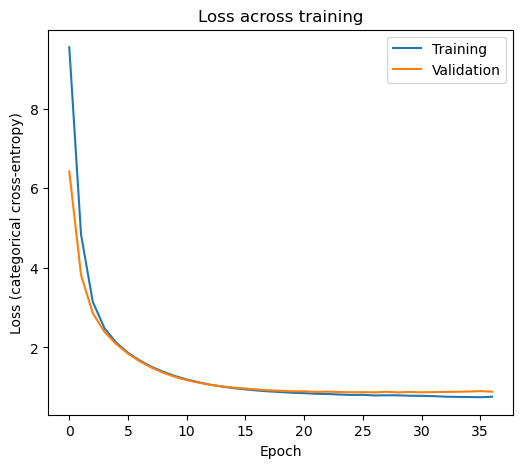

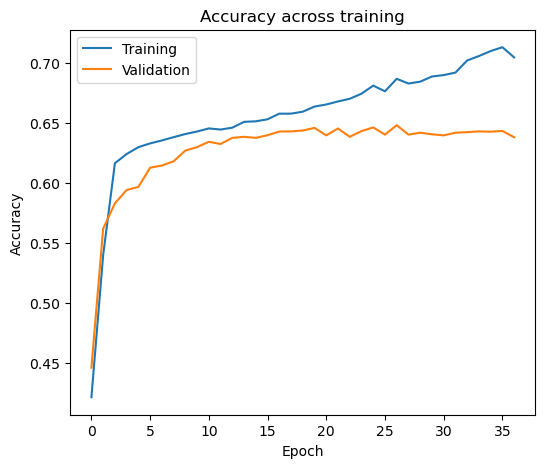

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(len(history.history['loss']))
y_train = history.history['loss']
y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (categorical cross-entropy)')
ax.legend()

plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(len(history.history['accuracy']))
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

plt.show()

# Training results

## Model

In [14]:
kappa = 0.15
nevent = '1000k'
save_model_name = f'best_model_CNN_kappa{kappa}-{nevent}/'
loaded_model = tf.keras.models.load_model(save_model_name)

## Testing data

In [15]:
kappa = 0.15
nevent = '1000k'
batch_size = 512
dim_image = [[75, 75], [[-0.8, 0.8], [-0.8, 0.8]]]
sample_dir = f'/home/r10222035/boosted_V_ML_test/sample/samples_kappa{kappa}-{nevent}/'
data_te = os.path.join(sample_dir, 'test.tfrecord')
dataset_te, te_total = get_dataset(data_te, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=0)

The data set contains images


In [16]:
results = loaded_model.evaluate(dataset_te)

print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

401/401 [==============================] - 17s 40ms/step - loss: 0.7734 - accuracy: 0.6837
Testing Loss = 0.773, Testing Accuracy = 0.684


## Plot ROC

In [17]:
labels = np.vstack([x[1] for x in dataset_te])

predictions = loaded_model.predict(dataset_te).tolist()

402/402 [==============================] - 17s 41ms/step


In [18]:
print(labels[:10])
print(predictions[:10])

y_test = np.argmax(labels, axis=1)
y_prob = np.array(predictions)

print(y_test[:10])
print(y_prob[:10])

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
[[0.07028122991323471, 0.8157346248626709, 0.11398415267467499], [0.47015273571014404, 0.3832373023033142, 0.14661002159118652], [0.6425790190696716, 0.035970501601696014, 0.32145047187805176], [0.15415681898593903, 0.7301802039146423, 0.11566303670406342], [0.2246897965669632, 0.6441853642463684, 0.1311248540878296], [0.058581143617630005, 0.10210803151130676, 0.8393108248710632], [0.08194722980260849, 0.8205496072769165, 0.09750308841466904], [0.26571667194366455, 0.5957603454589844, 0.13852298259735107], [0.747867226600647, 0.1381976306438446, 0.11393524706363678], [0.008910316973924637, 0.943183183670044, 0.047906454652547836]]
[1 0 0 1 0 2 1 2 0 2]
[[0.07028123 0.81573462 0.11398415]
 [0.47015274 0.3832373  0.14661002]
 [0.64257902 0.0359705  0.32145047]
 [0.15415682 0.7301802  0.11566304]
 [0.2246898  0.64418536 0.13112485]
 [0.05858114 0.10210803 0.83931082]
 

[1.98017269e+00 9.80172694e-01 9.73584652e-01 ... 2.22397898e-03
 2.22031772e-03 2.17161971e-04]
Calculating ACC


  2%|██▋                                                                                                                                     | 1147/59009 [00:15<13:11, 73.15it/s]


KeyboardInterrupt: 

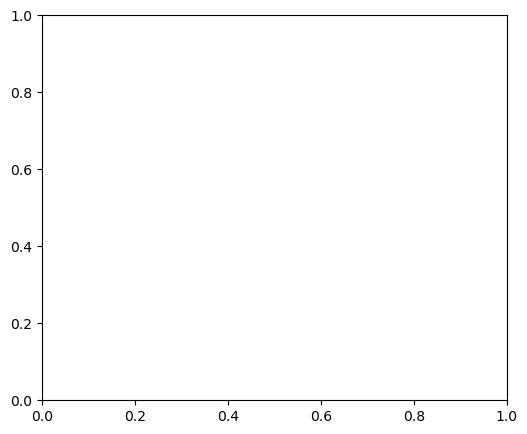

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

particle_type = {0: '$W^+$', 1: '$W^-$', 2: '$Z$    '}
AUC = [0,0,0]
ACC = [0,0,0]
for i in range(3):
    AUC[i] = roc_auc_score(y_test==i,  y_prob[:,i])
    fpr, tpr, threasholds = roc_curve(y_test==i, y_prob[:,i])
    print(threasholds)
    # 計算最高的正確率
    accuracy_scores = []
    print('Calculating ACC')
    for threshold in tqdm(threasholds):
        accuracy_scores.append(accuracy_score(y_test==i,  y_prob[:,i]>threshold))

    accuracies = np.array(accuracy_scores)
    ACC[i] = accuracies.max() 
    
    ax.plot(fpr, tpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')

ax.set_title(f'ROC of CNN$^2$ $\kappa = {kappa}$')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# plt.savefig(f'figures/ROC_CNN_kappa{kappa}-{nevent}.png', facecolor='White', dpi=300)
plt.show()

Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:15<00:00, 65.40it/s]
/tmp/ipykernel_853169/3837157490.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:14<00:00, 66.95it/s]
/tmp/ipykernel_853169/3837157490.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:14<00:00, 67.92it/s]
/tmp/ipykernel_853169/3837157490.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


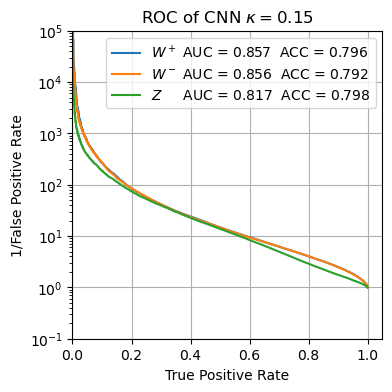

In [20]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

particle_type = {0: '$W^+$', 1: '$W^-$', 2: '$Z$    '}
AUC = [0,0,0]
ACC = [0,0,0]
for i in range(3):
    AUC[i] = roc_auc_score(y_test==i,  y_prob[:,i])
    fpr, tpr, thresholds = roc_curve(y_test==i, y_prob[:,i])

    # 計算最高的正確率
    accuracy_scores = []
    print('Calculating ACC')
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0,100,1001))

    for threshold in tqdm(thresholds):
        accuracy_scores.append(accuracy_score(y_test==i,  y_prob[:,i]>threshold))

    accuracies = np.array(accuracy_scores)
    ACC[i] = accuracies.max() 
    
    ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')

ax.set_title(f'ROC of CNN $\kappa = {kappa}$')
ax.set_xlabel('True Positive Rate')
ax.set_ylabel('1/False Positive Rate')
ax.set_xlim([0, 1.05])
ax.set_ylim([1e-1, 1e5])
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_yscale('log')
ax.legend()

plt.savefig(f'figures/ROC_CNN_kappa{kappa}-{nevent}-pstyle.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:15<00:00, 65.81it/s]
/tmp/ipykernel_853169/3398711447.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:15<00:00, 65.63it/s]
/tmp/ipykernel_853169/3398711447.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:14<00:00, 67.94it/s]
/tmp/ipykernel_853169/3398711447.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


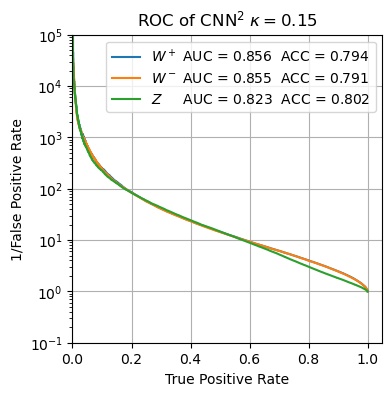

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

particle_type = {0: '$W^+$', 1: '$W^-$', 2: '$Z$    '}
AUC = [0,0,0]
ACC = [0,0,0]
for i in range(3):
    AUC[i] = roc_auc_score(y_test==i,  y_prob[:,i])
    fpr, tpr, thresholds = roc_curve(y_test==i, y_prob[:,i])

    # 計算最高的正確率
    accuracy_scores = []
    print('Calculating ACC')
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0,100,1001))

    for threshold in tqdm(thresholds):
        accuracy_scores.append(accuracy_score(y_test==i,  y_prob[:,i]>threshold))

    accuracies = np.array(accuracy_scores)
    ACC[i] = accuracies.max() 
    
    ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')

ax.set_title(f'ROC of CNN$^2$ $\kappa = {kappa}$')
ax.set_xlabel('True Positive Rate')
ax.set_ylabel('1/False Positive Rate')
ax.set_xlim([0, 1.05])
ax.set_ylim([1e-1, 1e5])
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_yscale('log')
ax.legend()

plt.savefig(f'figures/ROC_CNNsq_kappa{kappa}-{nevent}-pstyle.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

# Write training results

In [19]:
now = datetime.datetime.now()

In [20]:
file_name = 'CNN_training_results.csv'

In [25]:
df = pd.DataFrame({'kappa': [kappa],
                'Sample': [nevent],
                'Train W+': [train_size[0]],
                'Train W-': [train_size[1]],
                'Train Z':  [train_size[2]],
                'Validation W+': [validation_size[0]],
                'Validation W-': [validation_size[1]],
                'Validation Z':  [validation_size[2]],
                'Test W+': [test_size[0]],
                'Test W-': [test_size[1]],
                'Test Z':  [test_size[2]],
                'Overall ACC': [results[1]],
                'W+ AUC': [AUC[0]],
                'W+ ACC': [ACC[0]],
                'W- AUC': [AUC[1]],
                'W- ACC': [ACC[1]],
                'Z AUC':  [AUC[2]],
                'Z ACC':  [ACC[2]],
                'time': now,
                })
if os.path.isfile(file_name):
    training_results_df = pd.read_csv(file_name)
    pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
else:
    df.to_csv(file_name, index=False)

# Paper ROC

## Model

In [2]:
kappa = 0.15
nevent = '1000k'
CNN_model_name = f'best_model_CNN_kappa{kappa}-{nevent}/'
loaded_CNN = tf.keras.models.load_model(CNN_model_name)

kappa = 0.15
nevent = '1000k'
CNNsq_model_name = f'best_model_CNNsq_kappa{kappa}-{nevent}/'
loaded_CNNsq = tf.keras.models.load_model(CNNsq_model_name)

2022-11-21 10:34:42.966643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 10:34:46.248738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22286 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


## Testing data

In [3]:
kappa = 0.15
nevent = '1000k'
batch_size = 512
dim_image = [[75, 75], [[-0.8, 0.8], [-0.8, 0.8]]]
sample_dir = f'/home/r10222035/boosted_V_ML_test/sample/samples_kappa{kappa}-{nevent}/'
data_te = os.path.join(sample_dir, 'test.tfrecord')
dataset_te, te_total = get_dataset(data_te, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=0)

The data set contains images


In [4]:
results = loaded_CNN.evaluate(dataset_te)

print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

results = loaded_CNNsq.evaluate(dataset_te)

print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

2022-11-21 10:35:50.552591: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-11-21 10:35:56.150578: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-21 10:35:56.151456: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-21 10:35:56.151479: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-21 10:35:56.152254: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-21 10:35:56.152329: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-21 10:35:57.054149: I tensorflow/stream_executor/cuda/c

401/401 [==============================] - 22s 25ms/step - loss: 0.7734 - accuracy: 0.6837
Testing Loss = 0.773, Testing Accuracy = 0.684
401/401 [==============================] - 20s 46ms/step - loss: 0.7669 - accuracy: 0.6845
Testing Loss = 0.767, Testing Accuracy = 0.685


## Plot ROC

In [5]:
labels = np.vstack([x[1] for x in dataset_te])

predictions_CNN = loaded_CNN.predict(dataset_te).tolist()
predictions_CNNsq = loaded_CNNsq.predict(dataset_te).tolist()

402/402 [==============================] - 18s 45ms/step


In [6]:
y_test = np.argmax(labels, axis=1)
y_prob_CNN = np.array(predictions_CNN)
y_prob_CNNsq = np.array(predictions_CNNsq)

/tmp/ipykernel_885987/393142578.py:7: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = 'CNN')
/tmp/ipykernel_885987/393142578.py:9: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = 'CNN$^2$')


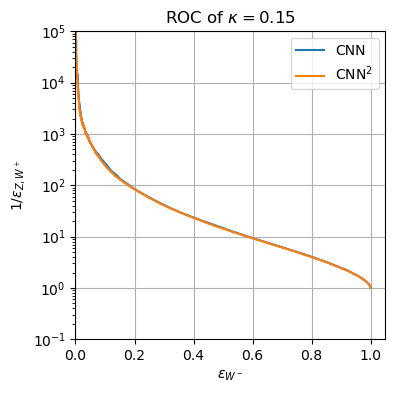

In [16]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

particle_type = {0: '$W^+$', 1: '$W^-$', 2: '$Z$    '}
AUC = [0,0,0]
ACC = [0,0,0]
fpr, tpr, thresholds = roc_curve(y_test==1, y_prob_CNN[:,1])
ax.plot(tpr, 1/fpr, label = 'CNN')
fpr, tpr, thresholds = roc_curve(y_test==1, y_prob_CNNsq[:,1])
ax.plot(tpr, 1/fpr, label = 'CNN$^2$')


ax.set_title(f'ROC of $\kappa = {kappa}$')
ax.set_xlabel('$\epsilon_{W^-}$')
ax.set_ylabel('$1/\epsilon_{Z,W^+}$')
ax.set_xlim([0, 1.05])
ax.set_ylim([1e-1, 1e5])
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_yscale('log')
ax.legend()

plt.savefig(f'figures/ROC_kappa{kappa}-{nevent}-pstyle-wm.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

/tmp/ipykernel_885987/1058772103.py:7: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = 'CNN')
/tmp/ipykernel_885987/1058772103.py:9: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = 'CNN$^2$')


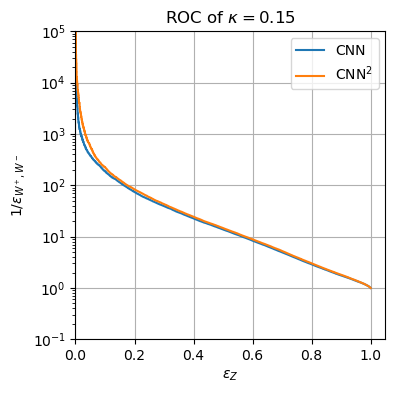

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

particle_type = {0: '$W^+$', 1: '$W^-$', 2: '$Z$    '}
AUC = [0,0,0]
ACC = [0,0,0]
fpr, tpr, thresholds = roc_curve(y_test==2, y_prob_CNN[:,2])
ax.plot(tpr, 1/fpr, label = 'CNN')
fpr, tpr, thresholds = roc_curve(y_test==2, y_prob_CNNsq[:,2])
ax.plot(tpr, 1/fpr, label = 'CNN$^2$')


ax.set_title(f'ROC of $\kappa = {kappa}$')
ax.set_xlabel('$\epsilon_{Z}$')
ax.set_ylabel('$1/\epsilon_{W^+,W^-}$')
ax.set_xlim([0, 1.05])
ax.set_ylim([1e-1, 1e5])
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_yscale('log')
ax.legend()

plt.savefig(f'figures/ROC_kappa{kappa}-{nevent}-pstyle-z.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()